<a href="https://colab.research.google.com/github/EmilisGit/Deep_learning/blob/main/NLP_ND.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
!pip install transformers datasets -q
!pip install markovify -q
!pip install num2words -q
!pip install pronouncing -q
!pip install nltk -q

In [37]:
import joblib
import os, re, time, string, json, random
import markovify
import pronouncing
import kagglehub

import pandas as pd
import numpy as np
import tensorflow as tf

from keras.models import load_model
from tqdm import tqdm
from num2words import num2words
from transformers import pipeline, set_seed as set_pipeline_seed
from transformers import DataCollatorForSeq2Seq, AutoTokenizer, TFAutoModelForSeq2SeqLM
from collections import defaultdict
from typing import List, Dict, Set
from datasets import load_dataset, Dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

resource_folder = "drive/MyDrive/Colab/NLP_ND"
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

#Sentimentų analizė


In [38]:
#@title Funkcijos
def print_metrics(test_y, preds):
  tn, fp, fn, tp = confusion_matrix(test_y, preds).ravel()
  accuracy = (tp + tn) / len(preds)
  precision = tp / (tp+fp)
  recall = tp / (tp+fn)
  f1 = 2 * precision * recall / (precision + recall)
  print(f'Accuracy: {accuracy:.2f}')
  print(f'Precision: {precision:.2f}')
  print(f'Recall: {recall:.2f}')
  print(f'F1: {f1:.2f}')

In [39]:
#@title Naive Bayes sentimentų klasifikatorius
class NaiveBayesClassifier:
    def __init__(self, stopwords_file_path):
        self.num_messages = {}
        self.log_class_priors = {}
        self.word_counts = {}
        self.vocab = set()
        self.stopwords = self.load_stopwords(stopwords_file_path)
        self.contractions = {
            "ain't": "is not",
            "aren't": "are not",
            "can't": "cannot",
            "can't've": "cannot have",
            "'cause": "because",
            "could've": "could have",
            "couldn't": "could not",
            "couldn't've": "could not have",
            "didn't": "did not",
            "doesn't": "does not",
            "don't": "do not",
            "hadn't": "had not",
            "hadn't've": "had not have",
            "hasn't": "has not",
            "haven't": "have not",
            "he'd": "he would",
            "he'd've": "he would have",
            "he'll": "he will",
            "he'll've": "he will have",
            "he's": "he is",
            "how'd": "how did",
            "how'd'y": "how do you",
            "how'll": "how will",
            "how's": "how is",
            "I'd": "I would",
            "I'd've": "I would have",
            "I'll": "I will",
            "I'll've": "I will have",
            "I'm": "I am",
            "I've": "I have",
            "isn't": "is not",
            "it'd": "it would",
            "it'd've": "it would have",
            "it'll": "it will",
            "it'll've": "it will have",
            "it's": "it is",
            "let's": "let us",
            "ma'am": "madam",
            "mayn't": "may not",
            "might've": "might have",
            "mightn't": "might not",
            "mightn't've": "might not have",
            "must've": "must have",
            "mustn't": "must not",
            "mustn't've": "must not have",
            "needn't": "need not",
            "needn't've": "need not have",
            "o'clock": "of the clock",
            "oughtn't": "ought not",
            "oughtn't've": "ought not have",
            "shan't": "shall not",
            "sha'n't": "shall not",
            "shan't've": "shall not have",
            "she'd": "she would",
            "she'd've": "she would have",
            "she'll": "she will",
            "she'll've": "she will have",
            "she's": "she is",
            "should've": "should have",
            "shouldn't": "should not",
            "shouldn't've": "should not have",
            "so've": "so have",
            "so's": "so is",
            "that'd": "that would",
            "that'd've": "that would have",
            "that's": "that is",
            "there'd": "there would",
            "there'd've": "there would have",
            "there's": "there is",
            "they'd": "they would",
            "they'd've": "they would have",
            "they'll": "they will",
            "they'll've": "they will have",
            "they're": "they are",
            "they've": "they have",
            "to've": "to have",
            "wasn't": "was not",
            "we'd": "we would",
            "we'd've": "we would have",
            "we'll": "we will",
            "we'll've": "we will have",
            "we're": "we are",
            "we've": "we have",
            "weren't": "were not",
            "what'll": "what will",
            "what'll've": "what will have",
            "what're": "what are",
            "what's": "what is",
            "what've": "what have",
            "when's": "when is",
            "when've": "when have",
            "where'd": "where did",
            "where's": "where is",
            "where've": "where have",
            "who'll": "who will",
            "who'll've": "who will have",
            "who's": "who is",
            "who've": "who have",
            "why's": "why is",
            "why've": "why have",
            "will've": "will have",
            "won't": "will not",
            "won't've": "will not have",
            "would've": "would have",
            "wouldn't": "would not",
            "wouldn't've": "would not have",
            "y'all": "you all",
            "y'all'd": "you all would",
            "y'all'd've": "you all would have",
            "y'all're": "you all are",
            "y'all've": "you all have",
            "you'd": "you would",
            "you'd've": "you would have",
            "you'll": "you will",
            "you'll've": "you will have",
            "you're": "you are",
            "you've": "you have"
            }

    def load_stopwords(self, path : str):
        if path:
            stopwords = pd.read_csv(path, header=None)[0].str.lower().tolist()
            stopwords.extend([
                "br", "span", "p", "div", "h1", "h2", "like", "film", "movie",
                "one", "would", "time", "really", "much", "even", "see", "story", "many"
            ])
        return stopwords

    def preprocess_text(self, text: str) -> List[str]:
        """
        Preprocess a single sentence: lowercase, remove non-alphanumeric characters, and split into words.
        """
        text = text.lower()


        # Expand contractions
        contractions_lower = {k.lower(): v.lower() for k, v in self.contractions.items()}
        pattern = re.compile(r'\b(' + '|'.join(contractions_lower.keys()) + r')\b')
        text = pattern.sub(lambda x: contractions_lower[x.group()], text)

        # Handle generic words
        generic_words_pattern = r'(\w+)\s+(good|bad|great)'
        text = re.sub(generic_words_pattern, r'\1-\2', text)

        # Tokenize and remove stopwords
        words = text.split()
        words = [word for word in words if word not in self.stopwords and re.match(r'^[a-zA-Z]+$', word)]

        return words

    def default_value(self):
        return 0

    def fit(self, x_train: pd.Series, y_train: pd.Series) -> None:
        """
        Fit the Naive Bayes model. Calculate prior probabilities and likelihoods from the training data.
        """
        n = len(x_train)

        self.num_messages['pos'] = sum(y_train)
        self.num_messages['neg'] = n - self.num_messages['pos']

        # using logarithms to later sum up, instead of multiplying probabilities
        self.log_class_priors['pos'] = np.log(self.num_messages['pos'] / n)
        self.log_class_priors['neg'] = np.log(self.num_messages['neg'] / n)

        # defaultdict provides a default value for a nonexistent key
        self.word_counts['pos'] = defaultdict(self.default_value)
        self.word_counts['neg'] = defaultdict(self.default_value)

        for x, y in zip(x_train, y_train):
            c = 'pos' if y == 1 else 'neg'
            words = self.preprocess_text(x)
            for word in words:
                if word:
                    self.vocab.add(word)
                    self.word_counts[c][word] += 1

    def predict(self, sentences: List[str]) -> List[int]:
        """
        Predict the sentiment of each sentence in sentences.
        """
        predictions = []
        for sentence in tqdm(sentences):
            words = self.preprocess_text(sentence)
            pos_score = 0
            neg_score = 0
            for word in words:
                if word in self.vocab:
                    # Add Laplace smoothing
                    log_w_given_pos = np.log((self.word_counts['pos'].get(word, 0) + 1) / (self.num_messages['pos'] + len(self.vocab)))
                    log_w_given_neg = np.log((self.word_counts['neg'].get(word, 0) + 1) / (self.num_messages['neg'] + len(self.vocab)))
                    pos_score += log_w_given_pos
                    neg_score += log_w_given_neg

            pos_score += self.log_class_priors['pos']
            neg_score += self.log_class_priors['neg']

            if pos_score > neg_score:
                predictions.append(1)
            else:
                predictions.append(0)
        return predictions

Naudojamas šiek tiek pakoreguotas ir daugiau apmokytas naivaus Bajeso modelis iš 1 laboratorinio darbo.

In [40]:
with open(f"{resource_folder}/naive_bayes_sentiment_model.pkl", 'rb') as file:
    naive_bayes_sentiment = joblib.load(file)

In [41]:
#@title Užkraunamas transformeris
set_pipeline_seed(42)
transformer_sentiment = pipeline("sentiment-analysis", model="distilbert/distilbert-base-uncased-finetuned-sst-2-english")

Device set to use cpu


In [42]:
#@title Užkraunamas atskiras duomenų rinkinys
ds = load_dataset("racro/sentiment-analysis-finetune")
dataset_test = ds['train'].shuffle(seed=42).select(range(100))
dataset_test[:5]

{'text': ['great software for blocking adverts i give it a 10/10 even though it may not block twitch adverts (because amazon is greedy) it has blocked over 5000 ads in the last 2 weeks\n',
  "the rotten tomatoes web-page which i use extensively started to open with no pictures.  i suspected cookies & so cleared them out but to no avail.  the next suspect was extensions &, as this was the last one added, i switched off & voila!  rotten tomatoes is now loading correctly.\n\nhaving 'all else failed', i've now read the instructions & disabled pb on rotten's site & all is well. doh!\n",
  'sexy. blocks most ads. some still get through and are not blockable (as in i will block them, but they will show up again after i refresh the page)\n',
  'i only have this issue with chrome canary and blur. this extension failed to redirect a network request to due to blur yadda yadda. yet i have these two working in regular chrome and firefox with no issues.\n',
  "most importantly gets rid of annoying a

100%|██████████| 100/100 [00:00<00:00, 1528.87it/s]


Naive Bayes prediction time: 0.0783 seconds
Accuracy: 0.59
Precision: 0.58
Recall: 0.66
F1: 0.62


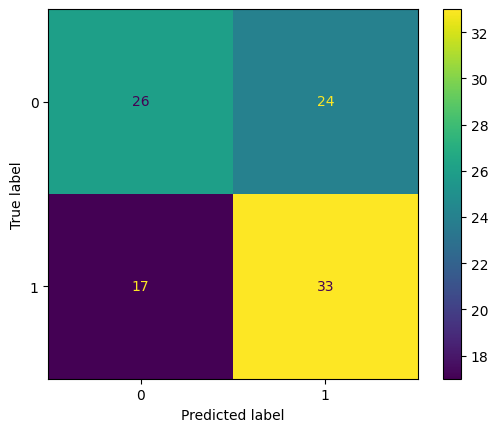

In [43]:
#@title Naivaus Bajeso rezultatai
start_time = time.time()
preds_naive_bayes = naive_bayes_sentiment.predict(dataset_test['text'])
naive_bayes_time = time.time() - start_time
print(f"Naive Bayes prediction time: {naive_bayes_time:.4f} seconds")
print_metrics(dataset_test['label'], preds_naive_bayes)
ConfusionMatrixDisplay.from_predictions(dataset_test['label'], preds_naive_bayes)

Transformer prediction time: 26.7984 seconds
Accuracy: 0.71
Precision: 0.77
Recall: 0.60
F1: 0.67


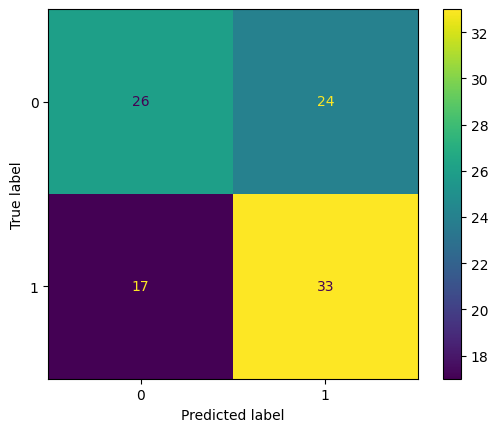

In [44]:
#@title Distilbert transformerio rezultatai
start_time = time.time()
preds_transformer = transformer_sentiment(dataset_test['text'])
preds_transformer = [1 if pred['label'] == 'POSITIVE' else 0 for pred in preds_transformer]
transformer_time = time.time() - start_time
print(f"Transformer prediction time: {transformer_time:.4f} seconds")
print_metrics(dataset_test['label'], preds_transformer)
ConfusionMatrixDisplay.from_predictions(dataset_test['label'], preds_naive_bayes)

Pagal rezultatus, matome, kad transformeris pasižymi geresniu tikslumu (accuracy 0.71, F1 0.67), tačiau yra žymiai lėtesnis (3.89 s) dėl sudėtingesnės architektūros. Naivus Bajeso modelis yra greitesnis (0.15 s), bet mažiau tikslus (accuracy 0.59, F1 0.62). Transformeris tinka, kai prioritetas – tikslumas, o Bajeso modelis – kai svarbus greitis ir paprastumas. Šiuo atvėju panaudotas galimai persimokęs naivaus Bajeso modelis, kadangi su šiuo atskiru testavimo duomenų rinkiniu, gautas žymiai prastesnis tikslumas.

#Poezijos, dainų generavimas

In [45]:
#@title Funkcijos

def create_transformers_dataset(file_contents):
    data = {"creator": list(file_contents.keys()), "text": list(file_contents.values())}

    return Dataset.from_dict(data)

def read_text_files_to_dict(folder_path):
    file_contents = {}
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):
            file_path = os.path.join(folder_path, file_name)

            with open(file_path, 'r', encoding='utf-8') as file:
                key = os.path.splitext(file_name)[0]
                file_contents[key] = file.read()[:5000]

    return file_contents

def normalize_word_line(line: str) -> list[str]:
  row = [x.lower() for x in re.findall(r"\w+'?\w*", line)]
  new_row = []
  for word in row:
    numbers = re.findall(r"\d+", word)
    for n in numbers:
      word = word.replace(n, num2words(int(n)))
    new_row.append(word)
  return new_row

def n_syllables(word_line: list[str]) -> int:
    vowels = 'aeiouy'
    syllable_count = 0

    for word in word_line:
        for i, char in enumerate(word):
            if char in vowels:
                if (i == 0) or (word[i-1] not in vowels):
                    syllable_count += 1
        word_vowels_count = sum([x in vowels for x in word])
        if word_vowels_count == 0:  # abreviaturos
            syllable_count = len(word)  # pvz. "NLP" skaitosi kaip "en-el-pi"
        elif word_vowels_count > 1 and (word[-1] == 'e') and (word[-2] not in vowels):  # paskutinė "e" dažnai nesakoma anglų k., bet "ie", "ee" ištariama
            syllable_count -= 1

    return syllable_count

def get_rhyme(line: list[str]) -> str:
    last_word = re.sub('\W+', '', line[-1])
    all_rhymes = pronouncing.rhymes(last_word)
    if all_rhymes:
        rhyming_ends = [x[-2:] for x in all_rhymes]
        most_common_rhyme = max(set(rhyming_ends), key=rhyming_ends.count)
    else:
        most_common_rhyme = last_word[-2:]
    return most_common_rhyme


def get_rhyme_list(normalized_lyrics: list[list[str]]):
  rhyme_set = set()
  for row in normalized_lyrics:
    most_common_rhyme = get_rhyme(row)
    rhyme_set.add(most_common_rhyme)

  sorted_rhyme_set = sorted(list(rhyme_set), key=lambda x: x[-1])
  return sorted_rhyme_set

def get_rhyme_float(line: list[str], rhyme_list: list[str]) -> float | None:
  rhyme = get_rhyme(line)
  if rhyme in rhyme_list:
    return rhyme_list.index(rhyme) / len(rhyme_list)
  else:
    return None

def length_test(sentence):
    max_words = 8
    return len(sentence.split()) <= max_words


def get_random_lines(markov_model, n_rows: int) -> list[list[str]]:
  lines = []
  last_words = []

  while len(lines) < n_rows:
    line = markov_model.make_short_sentence(max_chars=40)
    # nenorime gauti tuščios eilutės ar jau turimos eilutės
    if (line is not None) and (line not in lines):
      last_word = normalize_word_line(line)[-1]
      # nenorime kad dažnai pasikartotų tas pats žodis eilutės gale
      if last_words.count(last_word) < 3:
        lines.append(normalize_word_line(line))
        last_words.append(last_word)

  return lines


def get_line_features(line: list[str], rhyme_list: list[str]) -> tuple:
  return (line, n_syllables(line), get_rhyme_float(line, rhyme_list))

def build_dataset(lines: list[list[str]], rhyme_list: list[str]):
	features = [get_line_features(x, rhyme_list) for x in lines]
	x_data, y_data = [], []

  # turėsime standartinę struktūrą kai eilutės rimuojasi po 4 grupėje
	# pirmos dvi eilutės bus pradinės savybės, antros dvi eilutės - prognozuojamos
	for i in range(len(features) - 3):
		# duomenyse liks tik eilučių savybes, todėl visur [1:]
		line1, line2 = features[i    ][1:], features[i + 1][1:]
		line3, line4 = features[i + 2][1:], features[i + 3][1:]
		x_data.append(np.array([line1, line2]))
		y_data.append(np.array([line3, line4]))
	return np.array(x_data), np.array(y_data)

def compose(starting_input: np.ndarray, rnn_model, n_line_groups: int):
	final_vectors = []
	starting_vectors = rnn_model.predict(starting_input).flatten().reshape(1, 2, 2)
	final_vectors.append(starting_vectors)
	for i in range(n_line_groups):
		prev_vectors = final_vectors[-1]
		final_vectors.append(rnn_model.predict(prev_vectors).flatten().reshape(1, 2, 2))
	return final_vectors


def last_word_compare(prev_lines: list[list[str]], new_line: list[str], penalty: float = 0.2) -> float:
	sum_penalty = 0.0
	for line in prev_lines:
		if line[-1] == new_line[-1]:
			sum_penalty += penalty
	return sum_penalty


def calculate_score(features, n_syllables, rhyme, penalty: float, rhyme_list, maxsyllables):
	desired_n_syllables = features[0] * maxsyllables
	desired_rhyme = features[1] * len(rhyme_list)
	syllable_score = - abs(float(desired_n_syllables) - float(n_syllables))
	rhyme_score = 2.0 * abs(float(desired_rhyme) - float(rhyme))
	score = 1.0 + syllable_score + rhyme_score - penalty
	return score


def vectors_into_song(vectors, generated_lyrics, rhyme_list, maxsyllables: int):
	song = []
	generated_features = [get_line_features(x, rhyme_list) for x in generated_lyrics]

	vector_halves = []
	for vector in vectors:
		vector_halves.extend(vector[0].tolist())

	for vector in vector_halves:
		scorelist = []

		for (line, n_syllables, rhyme) in generated_features:
			if len(song) != 0:
				penalty = last_word_compare(song, line)
			else:
				penalty = 0

			total_score = calculate_score(vector, n_syllables, rhyme, penalty, rhyme_list, maxsyllables)
			scorelist.append([line, total_score])

		# randame eilutę su aukščiausiu įvertinimu
		best_line_index = np.argmax([float(x[1]) for x in scorelist])
		best_line = scorelist[best_line_index][0]
		song.append(best_line)

		# pašaliname šią eilutę iš likusių eilučių sąrašo
		generated_features = [x for x in generated_features if x[0] != best_line]

	return [' '.join(x) for x in song]

In [46]:
datapath = kagglehub.dataset_download("paultimothymooney/poetry")
data_files = os.listdir(datapath)
print(f'Downloaded {len(data_files)} files:', data_files)

Downloaded 49 files: ['jimi-hendrix.txt', 'lorde.txt', 'eminem.txt', 'joni-mitchell.txt', 'bjork.txt', 'lin-manuel-miranda.txt', 'blink-182.txt', 'janisjoplin.txt', 'dickinson.txt', 'lil-wayne.txt', 'prince.txt', 'nirvana.txt', 'lady-gaga.txt', 'disney.txt', 'Kanye_West.txt', 'radiohead.txt', 'beatles.txt', 'drake.txt', 'nicki-minaj.txt', 'bruce-springsteen.txt', 'paul-simon.txt', 'notorious_big.txt', 'michael-jackson.txt', 'bob-dylan.txt', 'al-green.txt', 'ludacris.txt', 'patti-smith.txt', 'nickelback.txt', 'kanye.txt', 'bieber.txt', 'alicia-keys.txt', 'notorious-big.txt', 'adele.txt', 'rihanna.txt', 'cake.txt', 'Lil_Wayne.txt', 'dj-khaled.txt', 'kanye-west.txt', 'nursery_rhymes.txt', 'dolly-parton.txt', 'johnny-cash.txt', 'bruno-mars.txt', 'britney-spears.txt', 'r-kelly.txt', 'dr-seuss.txt', 'bob-marley.txt', 'amy-winehouse.txt', 'missy-elliott.txt', 'leonard-cohen.txt']


Naudojamas LSTM modelis iš 2 laboratorinio darbo. Modeliui priskirti didesni lstm sluoksniai ir apmokytas ant daugiau epochų.

In [47]:
artist_files = ['kanye-west.txt']
raw_lyrics = ""
for file in artist_files:
  with open(os.path.join(datapath, file), 'r') as f:
      contents = f.read()
      raw_lyrics += contents + "\n"

markov_model = markovify.NewlineText(raw_lyrics)

lyrics = [normalize_word_line(x) for x in raw_lyrics.splitlines()]
lyrics = [x for x in lyrics if x]
rhymes = get_rhyme_list(lyrics)

x_data, y_data = build_dataset(lyrics, rhymes)
model = load_model(f"{resource_folder}/LSTM-based_lyrics_generator_kanye.keras")

start_time = time.time()
start_i = np.random.choice(range(len(x_data)))
start = np.array([x_data[start_i]])
vectors = compose(start, model, 10)
some_lyrics = get_random_lines(markov_model, 1000)
lstm_output = vectors_into_song(vectors, some_lyrics, rhymes, maxsyllables=8)
print(f"LSTM prediction time: {time.time() - start_time:.4f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
LSTM prediction time: 4.6794 seconds


In [48]:
text_files_dict = read_text_files_to_dict(datapath)

In [49]:
lyrics_dataset = create_transformers_dataset(text_files_dict)

In [50]:
tf.random.set_seed(42)
BASE_MODEL = "google/t5-efficient-small"
model = TFAutoModelForSeq2SeqLM.from_pretrained(BASE_MODEL)
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
INPUT_NAME = 'creator'
OUTPUT_NAME = 'text'

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at google/t5-efficient-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [51]:
def preprocess_data(examples):
    inputs = ["Write a song in the style of " + ex + ":" for ex in examples[INPUT_NAME]]
    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length")

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples[OUTPUT_NAME], max_length=512, truncation=True, padding=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

encoded_dataset = lyrics_dataset.map(preprocess_data, batched=True)

Map:   0%|          | 0/49 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3953: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [52]:
FINE_TUNED_MODEL_PATH = f"{resource_folder}/lyrics_generator_t5.keras"
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, return_tensors="tf")

if os.path.exists(FINE_TUNED_MODEL_PATH):
    model = TFAutoModelForSeq2SeqLM.from_pretrained(FINE_TUNED_MODEL_PATH)
else:
  tf_train_dataset = encoded_dataset.to_tf_dataset(
      columns=["input_ids", "attention_mask", "labels"],
      collate_fn=data_collator,
      shuffle=True,
      batch_size=8,
  )

  model.compile(optimizer="adam")
  model.fit(tf_train_dataset, epochs=30)
  model.save_pretrained(f"{resource_folder}/lyrics_generator_t5.keras")

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at drive/MyDrive/Colab/NLP_ND/lyrics_generator_t5.keras.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [53]:
def Generate_song(text):
    inference_text = tokenizer(text, return_tensors="tf", max_length=128, padding="max_length", truncation=True)

    outputs = model.generate(
        input_ids=inference_text["input_ids"],
        attention_mask=inference_text["attention_mask"],
        max_length=512,
        num_beams=2,
        temperature=0.85,
        repetition_penalty=2.5,
        early_stopping=True
    )

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_text

In [54]:
lstm_output

['just talked to jesus',
 'with them too long its medusa',
 'chillin in the media',
 'well have a baby by busta',
 'i cant come through wanna',
 'this a ghetto senorita',
 'spanish chick grab my hand',
 'lil boosie with the umbrella',
 'but im so polished',
 'got family in high school and',
 'then get my hands scrubbed',
 'and im beasting off the deep end',
 'and i dont get too loud',
 'baby just step back and smiled',
 'and your girlfriend hired',
 'your a princess and you dont mind',
 'she said you adopted',
 'man i had blood clots but i did',
 'whats scary to see id',
 'honey wanna know is why god',
 'so im on a period',
 'youre the girl that love hollywood']

In [55]:
start_time = time.time()
transformer_output = Generate_song("Write a song in the style of kanye-west:")
print(f"Transformer prediction time: {time.time() - start_time:.4f} seconds")
print(re.sub(r'(?= [A-Z])', '\n', transformer_output))

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.85` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Transformer prediction time: 140.8733 seconds
[Chorus]
 Its all a dream we had
 The day we meet our friends
 I know wet
 And when there is no place for us to turn
 Dont go to strangers, darling, come to me
 Cause
 I can't get no sleep
 So let us turn this thing around
 Let us turn this thing around and let us turn this thing around
 But when you need someone to feel so important
 Things gonna happen, don't go to strangers, darling, come to me
 Cause
 I cant get no sleep
 Cause
 I cant win? [Chorus]
 Its all good its aint no sunshine when we meet my friends
 I know we met in
 Paris got our girls cry
 So make a deal, dont go to strangers, darling, come to me
 I just leave your door
 We only said goodbye with words we said goodbye with words we said goodbye with words we said goodbye with words we said goodbye with words we said goodbye with words we said goodbye with words we said goodbye with words we said goodbye with words
 I said goodbye with words
 I said goodbye with words
 I said 

Lstm su Markovo grandine ir transformerio rezultatus sudėtinga tiksliai palyginti testais ar metrikomis. Kadangi Markovo grandinė generuoja atsitiktines žodžių sekas, lstm modelio dainos tekstas ne nuoseklus, žodžiai, nėra vienas su kitu susiję. Tačiau yra šioks toks ritmas, tvarkinga struktūra ir generuojamas tekstas daug greičiau (30x)

Visi išbandyti transformeriai, kuriuos būtų galima pasileisti lokaliai, nesugebėjo generuoti dainų be tolimesnio apmokymo. Fine-tuningui pasirinktas tas pats duomenų rinkinys, kaip naudotas lstm modeliui. Modelis - google/t5-efficient-small pasirinktas dėl daug resursų nereikalaujančio apmokymo. Transformerio modelis labai mėgsta atkartoti pagrindines frazes. Kad tai sumažinti, pakelta modelio temperatūra ir atkartotinų frazių bausmė. Taip pat, modelis mažai atsižvelgia į ritma, verčiau generuoja tekstą, kurį būtų galima dainuoti. Tam, kad rezultatą pagerinti, būtų galima padidinti apmokymo duomenų rinkinį, (šiuo atveju paimta, tik po vieną dainos atkarpą iš kiekvieno kūrėjo), taip pat geriau apdorojus duomenis.

#Teksto apibendrinimas

In [21]:
#@title Duomenų rinkinys
BBC_NEWS_SUMMARIES = load_dataset("Mahendrakharra/BBC-News-Articles-Summaries")
TEST_SAMPLE = BBC_NEWS_SUMMARIES['test'][0]['articles']
bleu_articles = BBC_NEWS_SUMMARIES['test']['articles'][:5]
bleu_summaries = BBC_NEWS_SUMMARIES['test']['summaries'][:5]

README.md:   0%|          | 0.00/434 [00:00<?, ?B/s]

(…)-00000-of-00001-2cd5c69d0b61c189.parquet:   0%|          | 0.00/3.51M [00:00<?, ?B/s]

(…)-00000-of-00001-bfe34c6073de01a8.parquet:   0%|          | 0.00/730k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1800 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/425 [00:00<?, ? examples/s]

In [22]:
def Summarize_text(model, text):
    inference_text = tokenizer("Summarize: " + text, return_tensors="tf", max_length=512, padding="max_length", truncation=True)

    outputs = model.generate(
        input_ids=inference_text["input_ids"],
        attention_mask=inference_text["attention_mask"],
        max_length=128,
        num_beams=3,
        early_stopping=True
    )

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_text

Naudojamas 3 laboratoriniame apmokytas teksto apibendrinimo google/t5-efficient-small modelis

In [23]:
tf.random.set_seed(42)
t5summarizer = TFAutoModelForSeq2SeqLM.from_pretrained(f"{resource_folder}/Summarization_t5_eff_small.keras")
tokenizer = AutoTokenizer.from_pretrained("google/t5-efficient-small")

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at drive/MyDrive/Colab/NLP_ND/Summarization_t5_eff_small.keras.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [24]:
start_time = time.time()
output = Summarize_text(t5summarizer, TEST_SAMPLE)
print(f"Summarization time: {time.time() - start_time}s.")
print(output)

Summarization time: 36.36257576942444s.
Weir, a young Irish League midfielder, joins Sunderland after a move to Stoke City. The 17-year-old Irish League midfielder was chased by Rangers and Fulham, but Mick McCarthy's side won the race. Larne boss Jimmy McGeough confirms he's joining Sunderland, but Larne boss Jimmy McGeough confirms Larne's agreement with interested clubs


In [25]:
#@title Summarization transformer pipeline
set_pipeline_seed(42)
distilbert_summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")

start_time = time.time()
output = distilbert_summarizer(TEST_SAMPLE)
print(f"Summarization time: {time.time() - start_time}s.")
print(output)

config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Device set to use cpu


Summarization time: 14.913481712341309s.
[{'summary_text': ' Robbie Weir is poised to join Sunderland after turning down Stoke City move . The 17-year-old Irish League midfielder was also being chased by Rangers and Fulham . But Larne boss Jimmy McGeough has yet to confirm that Weir is on his way from Inver Park .'}]


In [27]:
t5_generated_summaries = [Summarize_text(t5summarizer, summary) for summary in bleu_articles]
t5_generated_summaries

["Weir, a young Irish League midfielder, joins Sunderland after a move to Stoke City. The 17-year-old Irish League midfielder was chased by Rangers and Fulham, but Mick McCarthy's side won the race. Larne boss Jimmy McGeough confirms he's joining Sunderland, but Larne boss Jimmy McGeough confirms Larne's agreement with interested clubs",
 "Wenger's striker sacked by Chelsea after a drug test, sacked by Chelsea after a drug test. He faces a ban between six months and two years, but he faces a ban of between six months and two years. He argues he's sacked the striker after a drug test, sparked by Chelsea's decision. He believes he's not expected to sack him, but he",
 'England coach Andy Robinson\'s Six Nations defeat to Ireland; Rugby Football Union (RFU) investigates Robinson\'s comments on Kaplan\'s decision to disallow two England tries; Robinson\'s "livid" about Kaplan\'s decision to disallow two England tries; RFU\'s "livid" about Kaplan\'s decision to disallow two England tries; R

In [28]:
distilbert_generated_summaries_dict = distilbert_summarizer(bleu_articles)
distilbert_generated_summaries = [item['summary_text'] for item in distilbert_generated_summaries_dict]
distilbert_generated_summaries

[' Robbie Weir is poised to join Sunderland after turning down Stoke City move . The 17-year-old Irish League midfielder was also being chased by Rangers and Fulham . But Larne boss Jimmy McGeough has yet to confirm that Weir is on his way from Inver Park .',
 ' Adrian Mutu was sacked by Chelsea on Friday after testing positive for cocaine . Arsenal boss Arsene Wenger would consider signing the striker once he has served his ban . Mutu has hit out at Chelsea\'s decision to sack him saying: "Chelsea have destroyed me" Mutu faces a ban of between six months and two years when the Football Association decides on his punishment .',
 ' England coach Andy Robinson criticised referee Jonathan Kaplan in Six Nations defeat to Ireland . The Rugby Football Union (RFU) will investigate Robinson after deciding not to lodge a complaint against Kaplan . Robinson may even have to apologise for his comments in order to avoid sanction from the International Rugby Board . The England coach went on to cla

In [29]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

def calculate_bleu_scores(bleu_articles, bleu_summaries, generated_summaries):
  individual_scores = [
      sentence_bleu([ref.split()], gen.split(), weights=(0.25, 0.25, 0.25, 0.25))  # BLEU-4
      for ref, gen in zip(bleu_summaries, bleu_articles)
  ]

  corpus_score = corpus_bleu(
      [[ref.split()] for ref in bleu_summaries],
      [gen.split() for gen in generated_summaries],
      weights=(0.25, 0.25, 0.25, 0.25)  # BLEU-4
  )

  print("Individual BLEU Scores:", individual_scores)
  print("Corpus BLEU Score. Higher-better:", corpus_score)


In [30]:
print("Dataset and t5-summarization model BLEU scores")
calculate_bleu_scores(bleu_articles, bleu_summaries, t5_generated_summaries)
print("")
print("Dataset and distilbert-summarization model BLEU scores")
calculate_bleu_scores(bleu_articles, bleu_summaries, distilbert_generated_summaries)

Dataset and t5-summarization model BLEU scores
Individual BLEU Scores: [0.2955358223347861, 0.41905257702452037, 0.3034678884873291, 0.3945586270560725, 0.4422914355125415]
Corpus BLEU Score. Higher-better: 0.01762219574190369

Dataset and distilbert-summarization model BLEU scores
Individual BLEU Scores: [0.2955358223347861, 0.41905257702452037, 0.3034678884873291, 0.3945586270560725, 0.4422914355125415]
Corpus BLEU Score. Higher-better: 0.05858016295981314


Įvertinti šių modelių rezultatą pasinaudota bleu testu. BLEU matuoja, kiek sugeneruotame tekste esantys n-gramai (žodžių sekos iš n žodžių, pvz., unigramai, bigramai ir pan.) sutampa su n-gramais originaliame tekste. Distilbart pasiekė gana geresnį BLEU įvertį, kas reiškia, kad šio modelio apibendrintas tekstas geriau atitinka duomenų rinkinio tekstų apibendrinimus. Tačiau, abu modeliai gana gerai sumarizuoja tekstą.
Sshleifer/distilbart-cnn-12-6 - standartinis transformers pipeline modelis summarizavimo užduotims. Nors šis modelis daug didesnis už t5-efficient-small, jis generuoja atsakymus apie 4 kartus greičiau ir gautas rezultatas šiek tiek geresnis.